# SET UP

In [1]:
!pip install ekphrasis

     |████████████████████████████████| 80 kB 3.3 MB/s 
     |████████████████████████████████| 215 kB 27.4 MB/s 
     |████████████████████████████████| 64 kB 2.0 MB/s 
  Created wheel for ekphrasis: filename=ekphrasis-0.5.1-py3-none-any.whl size=82842 sha256=8d4f2656c5490842c0f629f652bb2e9e3af6ee11b5ad4e0f4950e96a7c877153
  Stored in directory: /root/.cache/pip/wheels/f7/ec/0d/12659e32faf780546945d0120f2c8410eb3efb7426731da88f
  Created wheel for ftfy: filename=ftfy-6.0.3-py3-none-any.whl size=41933 sha256=cc6b44a0e0dbe5502370081c55c5dbfd94f3b38484ddf2e2c3163df1e82d0abd
  Stored in directory: /root/.cache/pip/wheels/19/f5/38/273eb3b5e76dfd850619312f693716ac4518b498f5ffb6f56d
Successfully built ekphrasis ftfy


In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/DL/Proj

Mounted at /content/drive
/content/drive/MyDrive/DL/Proj


In [3]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import optim
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

# PREPROCESS

## Text Preprocess

In [5]:
data_dir = 'data/'

In [6]:
from ekphrasis.classes.preprocessor import TextPreProcessor
from ekphrasis.classes.tokenizer import SocialTokenizer
from ekphrasis.dicts.emoticons import emoticons

In [7]:
emoticons_add = {
    '(^・^)': '<happy>', ':‑c': '<sad>', '=‑d': '<happy>', ":'‑)": '<happy>', ':‑d': '<laugh>',
    ':‑(': '<sad>', ';‑)': '<happy>', ':‑)': '<happy>', ':\\/': '<sad>', 'd=<': '<annoyed>',
    ':‑/': '<annoyed>', ';‑]': '<happy>', '(^�^)': '<happy>', 'angru': 'angry', "d‑':":
        '<annoyed>', ":'‑(": '<sad>', ":‑[": '<annoyed>', '(�?�)': '<happy>', 'x‑d': '<laugh>',
}

In [8]:
text_processor = TextPreProcessor(
    # terms that will be normalized
    normalize=['url', 'email', 'percent', 'money', 'phone', 'user',
               'time', 'url', 'date', 'number'],
    # terms that will be annotated
    annotate={"hashtag", "allcaps", "elongated", "repeated",
              'emphasis', 'censored'},
    fix_html=True,  # fix HTML tokens
    # corpus from which the word statistics are going to be used 
    # for word segmentation 
    segmenter="twitter",
    # corpus from which the word statistics are going to be used 
    # for spell correction
    corrector="twitter",
    unpack_hashtags=True,  # perform word segmentation on hashtags
    unpack_contractions=True,  # Unpack contractions (can't -> can not)
    spell_correct_elong=True,  # spell correction for elongated words
    # select a tokenizer. You can use SocialTokenizer, or pass your own
    # the tokenizer, should take as input a string and return a list of tokens
    tokenizer=SocialTokenizer(lowercase=True).tokenize,
    # list of dictionaries, for replacing tokens extracted from the text,
    # with other expressions. You can pass more than one dictionaries.
    dicts=[emoticons, emoticons_add]
)

/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/tokenizer.py:225: FutureWarning: Possible nested set at position 2190
  self.tok = re.compile(r"({})".format("|".join(pipeline)))


Word statistics files not found!
Downloading... done!
Unpacking... done!
Reading twitter - 1grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_1grams.txt
Reading twitter - 2grams ...
generating cache file for faster loading...
reading ngrams /root/.ekphrasis/stats/twitter/counts_2grams.txt
Reading twitter - 1grams ...


/usr/local/lib/python3.7/dist-packages/ekphrasis/classes/exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


In [9]:
emo2label = {'happy': 0, 'sad': 1, 'angry': 2, 'others': 3}
label2meo = {0: 'happy', 1: 'sad', 2: 'angry', 3: 'others'}

In [10]:
train_data = pd.read_csv(data_dir+'train.txt', sep='\t').drop(columns='id')
test_data  = pd.read_csv(data_dir+'test.txt', sep='\t').drop(columns='id')
dev_data   = pd.read_csv(data_dir+'dev.txt', sep='\t').drop(columns='id')

In [11]:
def preprocess_data(data_path):
    # read dataframe
    df = pd.read_csv(data_path, sep='\t').drop(columns='id')
    # preprocess texts
    df.turn1 = df.turn1.apply(text_processor.pre_process_doc)
    df.turn2 = df.turn2.apply(text_processor.pre_process_doc)
    df.turn3 = df.turn3.apply(text_processor.pre_process_doc)
    
    df.label = df.label.apply(lambda x: emo2label[x])

    return df
    

In [12]:
train_data = preprocess_data(data_dir+'train.txt')
test_data  = preprocess_data(data_dir+'test.txt')
dev_data   = preprocess_data(data_dir+'dev.txt')

## Tokenization

In [13]:
def getEmbeddings(file):

    embeddingsIndex = {}
    dim = 0
    with open(file, encoding="utf8") as f:
        for line in f:
            values = line.split()
            word = values[0]
            embeddingVector = np.asarray(values[1:], dtype='float32')
            embeddingsIndex[word] = embeddingVector 
            dim = len(embeddingVector)

    return embeddingsIndex, dim


def getEmbeddingMatrix(wordIndex, embeddings, dim):

    embeddingMatrix = np.zeros((len(wordIndex) + 1, dim))
    for word, i in wordIndex.items():
        embeddingMatrix[i] = embeddings.get(word)

    return embeddingMatrix

In [14]:
from keras.preprocessing.text import Tokenizer

embeddings, dim = getEmbeddings(data_dir+'embeddings_300d.txt')
tokenizer = Tokenizer(filters='', oov_token='UKN')
tokenizer.fit_on_texts([' '.join(list(embeddings.keys()))])

wordIndex = tokenizer.word_index
print("Found %s unique tokens." % len(wordIndex))

embeddings_matrix = getEmbeddingMatrix(wordIndex, embeddings, dim)
embeddings_matrix[1] = np.random.normal(0, 0.1, 300)

Found 658126 unique tokens.


In [15]:
def get_input_data(df):

    x = []
    for i in tqdm(range(df.shape[0])):
        turn1 = tokenizer.texts_to_sequences(df.loc[i, 'turn1'])
        turn1 = [x for x in turn1 if len(x)==1]
        turn1 = torch.tensor(turn1).squeeze(dim=1).to(device)
        turn2 = tokenizer.texts_to_sequences(df.loc[i, 'turn2'])
        turn2 = [x for x in turn2 if len(x)==1]
        turn2 = torch.tensor(turn2).squeeze(dim=1).to(device)
        turn3 = tokenizer.texts_to_sequences(df.loc[i, 'turn3'])
        turn3 = [x for x in turn3 if len(x)==1]
        turn3 = torch.tensor(turn3).squeeze(dim=1).to(device)

        x.append(np.array([turn1, turn2, turn3]))
    
    x = np.array(x)
    y = torch.tensor(df.label).to(device)

    return x, y
    

In [16]:
train_x, train_y = get_input_data(train_data)
test_x, test_y = get_input_data(test_data)
dev_x, dev_y = get_input_data(dev_data)

  0%|          | 0/30160 [00:00<?, ?it/s]

  0%|          | 0/5509 [00:00<?, ?it/s]

  0%|          | 0/2755 [00:00<?, ?it/s]

# SETTINGS

## Define Loader

In [17]:
from collections.abc import Iterable, Iterator
from random import shuffle

class DataLoader(Iterable):
    def __init__(self, x, y, batch_size, shuffle):
        self._x = x
        self._y = y
        self._batch_size = batch_size
        self._shuffle = shuffle
    
    def __iter__(self):
        if self._shuffle:
            tmp = list(zip(self._x, self._y))
            shuffle(tmp)
            self._x, self._y = zip(*tmp)
            self._x = np.array(self._x)
            self._y = torch.tensor(self._y).to(device)
        
        return DataIterator(self)
    
    def __len__(self):
        return len(self._y)

    def __getitem__(self, idx):
        return (self._x[idx], self._y[idx])

In [18]:
class DataIterator(Iterator):
    def __init__(self, data):
        self._data = data
        self._idx = 0
    
    def __next__(self):
        if self._idx < len(self._data._x):
            batch_x = self._data._x[self._idx:self._idx+self._data._batch_size]
            batch_y = self._data._y[self._idx:self._idx+self._data._batch_size]
            self._idx += self._data._batch_size
            return batch_x, batch_y

        raise StopIteration

## Metric

In [19]:
def accuracy(y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    acc = torch.sum(y_pred == y) / y_pred.shape[0]
    return acc

In [20]:
def f1_score(conf):
    TP = torch.tensor([conf[i, i] for i in range(4)])
    FP = torch.sum(conf, 1) - TP
    FN = torch.sum(conf, 0) - TP
    P = TP / (TP + FP + 1e-5)
    R = TP / (TP + FN + 1e-5)
    F1 = torch.mean(2 / (1/P+1/R))
    return P, R, F1

In [21]:
def confusion_add(conf, y_pred, y):
    y_pred = torch.argmax(y_pred, dim=1)
    for i in range(len(y)):
        conf[y_pred[i], y[i]] += 1

In [22]:
def criterion(y_pred, y):
    return F.cross_entropy(y_pred, y)

## Train and Evaluate

In [23]:
def train(model, loader, optimizer, scheduler, criterion):

    model.train()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    for x, y in loader:
        optimizer.zero_grad()

        y_pred = model(x)

        loss = criterion(y_pred, y)
        acc  = accuracy(y_pred, y)
        confusion_add(conf, y_pred, y)

        loss.backward()
        optimizer.step()

        epoch_loss += [loss.item()]
        epoch_acc  += [acc.item()]
    
    scheduler.step()

    return np.mean(epoch_loss), np.mean(epoch_acc), conf


In [24]:
def evaluate(model, loader, criterion):

    model.eval()

    epoch_loss = []
    epoch_acc  = []
    conf = torch.zeros(4, 4)

    with torch.no_grad():
        for x, y in loader:
            y_pred = model(x)

            loss = criterion(y_pred, y)
            acc  = accuracy(y_pred, y)
            confusion_add(conf, y_pred, y)

            epoch_loss += [loss.item()]
            epoch_acc  += [acc.item()]

    return np.mean(epoch_loss), np.mean(epoch_acc), conf


# 3-LSTM

## Model

In [25]:
class EMOLSTM(nn.Module):
    def __init__(self, embeddings_matrix, input_dim, output_dim, lstm_hidden_dim, decode_hidden_dim, dropout):

        super().__init__()
        
        self.embedding = nn.Embedding(embeddings_matrix.shape[0], embeddings_matrix.shape[1])
        self.embedding.weight = nn.Parameter(torch.tensor(embeddings_matrix, dtype=torch.float), requires_grad=False)

        self.lstm_1 = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=1, batch_first=True, bidirectional=True)
        self.lstm_2 = nn.LSTM(input_dim, lstm_hidden_dim, num_layers=1, batch_first=True, bidirectional=True)

        self.h0_1 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(2, 1, lstm_hidden_dim)), requires_grad=True)
        self.h0_2 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(2, 1, lstm_hidden_dim)), requires_grad=True)
        self.c0_1 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(2, 1, lstm_hidden_dim)), requires_grad=True)
        self.c0_2 = nn.Parameter(nn.init.xavier_normal_(torch.Tensor(2, 1, lstm_hidden_dim)), requires_grad=True)

        self.decode = nn.Sequential(
            nn.Linear(3*lstm_hidden_dim, decode_hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(decode_hidden_dim, decode_hidden_dim),
            nn.Dropout(dropout),
            nn.PReLU(),
            nn.Linear(decode_hidden_dim, output_dim)
        )


    def forward(self, x):

        x_ = []
        for i in range(x.shape[0]):
            turn1 = self.embedding(x[i][0]).unsqueeze(dim=0)
            turn2 = self.embedding(x[i][1]).unsqueeze(dim=0)
            turn3 = self.embedding(x[i][2]).unsqueeze(dim=0)

            _, (turn1_hn, _) = self.lstm_1(turn1, (self.h0_1, self.c0_1))
            _, (turn2_hn, _) = self.lstm_2(turn2, (self.h0_2, self.c0_2))
            _, (turn3_hn, _) = self.lstm_1(turn3, (self.h0_1, self.c0_1))

            xi = torch.concat([turn1_hn, turn2_hn, turn3_hn], dim=-1)
            xi = torch.mean(xi, dim=0)
            x_.append(xi)

        x = torch.concat(x_, dim=0)
        x = self.decode(x)

        return x


## Experiment

In [26]:
BATCH_SIZE = 20

train_loader = DataLoader(train_x, train_y, batch_size=BATCH_SIZE, shuffle=True)
test_loader  = DataLoader(test_x, test_y, batch_size=BATCH_SIZE, shuffle=True)
dev_loader   = DataLoader(dev_x, dev_y, batch_size=BATCH_SIZE, shuffle=True)

In [27]:
model_path = 'models/EMOLSTM.pth'

model = EMOLSTM(embeddings_matrix, embeddings_matrix.shape[1], 4, 128, 32, 0.3)
model = model.to(device)
optimizer = optim.Adam(model.parameters(), lr=0.003, weight_decay=0.01)
scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.8, verbose=True)

Adjusting learning rate of group 0 to 3.0000e-03.


In [28]:
N_EPOCH = 15

train_loss_list, dev_loss_list = [], []
min_f1 = 0

for epoch in range(N_EPOCH):
    train_loss, train_acc, train_conf = train(model, train_loader, optimizer, scheduler, criterion)
    dev_loss, dev_acc, dev_conf = evaluate(model, dev_loader, criterion)

    train_loss_list.append(train_loss)
    dev_loss_list.append(dev_loss)

    dev_P, dev_R, dev_f1 = f1_score(dev_conf)
    if dev_f1 > min_f1:
        torch.save(model.state_dict(), model_path)
        min_f1 = dev_f1

    print('[epoch %02d] train loss: %2.2f, dev loss: %2.2f, dev accuracy: %2.2f%%, dev f1 score: %2.2f%%' %
          (epoch+1, train_loss, dev_loss, dev_acc*100, dev_f1*100))
    print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
          (dev_P[0], dev_P[1], dev_P[2], dev_P[3], dev_R[0], dev_R[1], dev_R[2], dev_R[3]))

Adjusting learning rate of group 0 to 2.4000e-03.
[epoch 01] train loss: 0.93, dev loss: 0.44, dev accuracy: 84.61%, dev f1 score: 64.64%
P: 0.60 0.74 0.33 0.94 | R: 0.48 0.65 0.71 0.89
Adjusting learning rate of group 0 to 1.9200e-03.
[epoch 02] train loss: 0.53, dev loss: 0.41, dev accuracy: 87.87%, dev f1 score: 70.80%
P: 0.47 0.56 0.67 0.96 | R: 0.70 0.77 0.70 0.91
Adjusting learning rate of group 0 to 1.5360e-03.
[epoch 03] train loss: 0.47, dev loss: 0.30, dev accuracy: 90.27%, dev f1 score: 72.10%
P: 0.64 0.84 0.58 0.95 | R: 0.65 0.54 0.71 0.95
Adjusting learning rate of group 0 to 1.2288e-03.
[epoch 04] train loss: 0.45, dev loss: 0.31, dev accuracy: 90.13%, dev f1 score: 74.51%
P: 0.60 0.80 0.58 0.96 | R: 0.69 0.66 0.79 0.93
Adjusting learning rate of group 0 to 9.8304e-04.
[epoch 05] train loss: 0.43, dev loss: 0.49, dev accuracy: 84.83%, dev f1 score: 68.93%
P: 0.62 0.48 0.43 0.97 | R: 0.71 0.84 0.90 0.85
Adjusting learning rate of group 0 to 7.8643e-04.
[epoch 06] train los

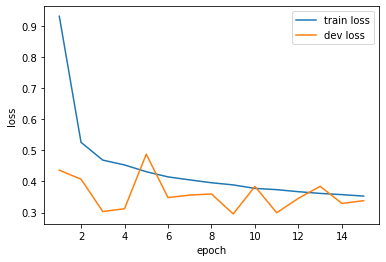

In [29]:
plt.figure()
plt.plot(np.arange(1, N_EPOCH+1), train_loss_list, label='train loss')
plt.plot(np.arange(1, N_EPOCH+1), dev_loss_list, label='dev loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.savefig('user-bilstm-glove.png')
plt.show()

In [30]:
model = EMOLSTM(embeddings_matrix, embeddings_matrix.shape[1], 4, 128, 32, 0.3)
model.load_state_dict(torch.load(model_path))
model = model.to(device)
model.eval()


test_loss, test_acc, test_conf = evaluate(model, test_loader, criterion)

test_P, test_R, test_f1 = f1_score(test_conf)

print('test loss: %2.2f, test accuracy: %2.2f%%, test f1 score: %2.2f%%' %
      (test_loss, test_acc*100, test_f1*100))
print('P: %.2f %.2f %.2f %.2f | R: %.2f %.2f %.2f %.2f' %
      (test_P[0], test_P[1], test_P[2], test_P[3], test_R[0], test_R[1], test_R[2], test_R[3]))

test loss: 0.30, test accuracy: 90.17%, test f1 score: 75.36%
P: 0.61 0.68 0.62 0.96 | R: 0.71 0.75 0.81 0.93
